# ISLR- Python Ch6 -- Lab 1: Subset Selection Methods 

In [45]:
# perform standard imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm # a python package that provides progress bars for iterables
from operator import itemgetter
from itertools import combinations
from sklearn.model_selection import KFold

## Loading Data

Here we apply the subset selection methods to the Hitters data. We wish to predict a baseball player’s Salary on the basis of various statistics associated with performance in the previous year.

First of all, we note that the Salary variable is missing for some of the players.

In [2]:
# Load the Hitters dataset. Pandas offers great flexibillity with dealing with missing values as keywords to 
# pd.read but lets read in all values so we can see how many we are missing.
hitters = pd.read_csv('Data/Hitters.csv', index_col=0)

# Get the number of players and the number of players with missing values
print('Hitters contains', len(hitters), 'players.')
num_missing = np.sum(hitters.isnull().any(axis=1))
print('We are missing data for', num_missing, 'players.')

# now remove the missing players for dataframe
hitters = hitters.dropna()
print('After removal Hitters contains', len(hitters), 'players.')
print('Shape=', hitters.shape)
hitters.head()

Hitters contains 322 players.
We are missing data for 59 players.
After removal Hitters contains 263 players.
Shape= (263, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Notice that columns League, Division and NewLeague are categorical. We will need to make dummy variables for these.

In [3]:
# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
-Alan Ashby,0,1,0,1,0,1
-Alvin Davis,1,0,0,1,1,0
-Andre Dawson,0,1,1,0,0,1
-Andres Galarraga,0,1,1,0,0,1
-Alfredo Griffin,1,0,0,1,1,0


In [4]:
# Generate new dataframe with new dummy variables
df = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
# add new dummy variables
df = pd.concat([df, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)
df.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0


## Best Subset Selection

Best subset selection forms every possible model from the predictors. It then compares models with the same nuber of predictors using RSS or R^2. Once the best model is picked for a given number of predictors, Models with different numbers of predictors are compared using one of the information criteria (AIC, BIC, Adj R^2), or by Cross-validation to select from among the models the model with the lowest TEST MSE.

In general, this method is not used because the computational cost is high. For a model with p-predictors, we must consider 2^p models. As such there is not a 'built-in' sklearn module for doing this. We will write a few helper functions to accomplish model selection.

In [5]:
def best_subsets(dataframe, predictors, response, max_features=8):
    """
    Regresses response onto subsets of the predictors in dataframe. Compares models with equal feature 
    numbers choosing the one with the lowest RSS as the 'best' model for that number of features.
    
    PARAMETERS
    ----------
    dataframe : pandas dataframe obj containing responses and predictors
    predictors : list of column names of dataframe used as features
    response : list of column name of dataframe used as target
    
    RETURNS
    -------
    a list of best models, one per feature number
    
    ex.
    [best 1 feat model, best two feat model] = best_subsets(df, predictors, response, max_features = 2)
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(dataframe[features])
        y = dataframe[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def get_best_kth_model(k):
        """
        Returns the model from all models with k-predictors with the lowest RSS.
        """
        results = []

        for combo in combinations(predictors, k):
            # process linear model with this combo of features
            results.append(process_linear_model(list(combo)))

        # sort the models and return the one with the smallest RSS
        return sorted(results, key=itemgetter(1)).pop(0)[0]
    
    models =[]
    for k in tqdm(range(1,max_features+1)):
        models.append(get_best_kth_model(k))
    
    return models

In [6]:
# call our best_subsets function
predictors = list(df.columns)
predictors.remove('Salary')
models = best_subsets(df, predictors, ['Salary'], max_features=19)

 32%|███▏      | 6/19 [03:07<06:45, 31.22s/it]

KeyboardInterrupt: 

In [31]:
# Output the best set of variables for each model size.
for model in models:
    print(model.model.exog_names)

['const', 'CRBI']
['const', 'Hits', 'CRBI']
['const', 'Hits', 'CRBI', 'PutOuts']
['const', 'Hits', 'CRBI', 'PutOuts', 'Division_W']
['const', 'AtBat', 'Hits', 'CRBI', 'PutOuts', 'Division_W']
['const', 'AtBat', 'Hits', 'Walks', 'CRBI', 'PutOuts', 'Division_W']
['const', 'Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts', 'Division_W']
['const', 'AtBat', 'Hits', 'Walks', 'CHmRun', 'CRuns', 'CWalks', 'PutOuts', 'Division_W']
['const', 'AtBat', 'Hits', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Division_W']
['const', 'AtBat', 'Hits', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Division_W']
['const', 'AtBat', 'Hits', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'League_N', 'Division_W']
['const', 'AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'League_N', 'Division_W']
['const', 'AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors'

In [33]:
# We can also look at the R^2 values.
for model in models:
    print(model.rsquared)

0.321450088668
0.425223746467
0.451429415718
0.475406653395
0.490803615964
0.508714557359
0.514122682361
0.528556860303
0.534612447792
0.540494950941
0.542615325425
0.543630208632
0.544457014232
0.545216356301
0.545469230681
0.545765557485
0.545951808077
0.546094522342
0.546115861913


We see that the $R^2$ statistic increases from 32%, when only one variable is included in the model, to almost 55%, when all variables are included. As expected, the $R^2$ statistic increases monotonically as more variables are included.

Plotting adjusted R2 , Cp , and BIC for all of the models at once will help us decide which model to select.

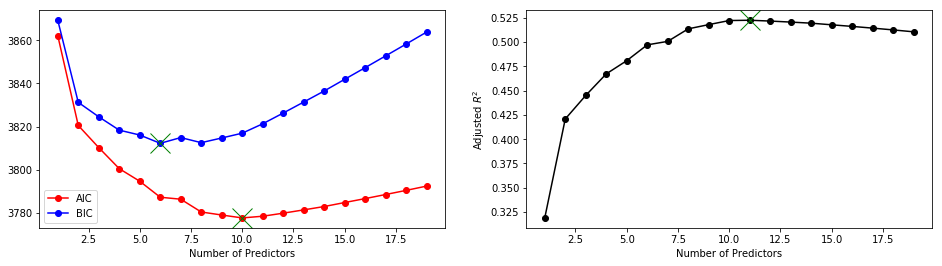

In [34]:
# Now that we have the best models for a given number of varaibles we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model for baseball player salary.
aics = [model.aic for model in models]
bics = [model.bic for model in models]
r_adj = [model.rsquared_adj model in models]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1, len(models), len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

# Plots
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel(r'Adjusted $R^2$');

So all the estimates of the test error indicate we need a model with more than 5 predictors. The AIC and Adj $R^2$ indicate 10-11 predictors and the BIC statistic indcates 6 predictors.

In [78]:
# The Lowest BIC model has the following coeffecients
models[5].params

const          91.511798
AtBat          -1.868589
Hits            7.604398
Walks           3.697647
CRBI            0.643017
PutOuts         0.264308
Division_W   -122.951534
dtype: float64

## Forward and Backward Stepwise Selection

As with Best-Subset Selection, we will need to custom write methods for performing Forward and Backward Stepwise selection. In sklearn there is a method called recusrsive feature elimination similar to Backward Stepwise Selection, but no methods I can find for Forward Selection.

The Forward Stepwise Selection algortihm sequentially adds predictors to the null model selecting the predictors that result in the lowest RSS for each added predictor. It then compares models with different features using Information Criteria or Cross-Validatation.

In [13]:
def forward_step_select(df, predictors, response, max_features=len(predictors)):
    """
    Regresses response onto predictors using a forward step algorithm. Features are added based on minimum RSS.
    
    PARAMETERS
    -----------
    df : dataframe containing predictors and responses
    predictors : list of all possible model predictors
    response : list[variable] to regress onto predictors in df
    max_features : maximum number of features to use from predictors list
    
    RETURNS
    --------
    list of models with increasing number of features upto max_features
    
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features, remaining_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
            
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:
        
        # get the best new feature set from update_model
        new_features, new_model = update_model(best_features, remaining_features)
        # update the best features to include the one we just found
        best_features = new_features  
        # reduce the available features for the next round
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        # append the new_features and model so we can compare models with different features later
        models.append(new_model)
        
    return models

In [14]:
# Call our forward step function
# set up inputs
predictors = list(df.columns)
predictors.remove('Salary')
# call forward_step_select
mods = forward_step_select(df,predictors,['Salary'],max_features=19)

In [15]:
# Output the best set of variables for each model size.
for model in mods:
    print(model.model.exog_names)

['const', 'CRBI']
['const', 'CRBI', 'Hits']
['const', 'CRBI', 'Hits', 'PutOuts']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League_N']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League_N', 'Runs']
['const', 'CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'Leagu

For instance, we see that using forward stepwise selection, the best one-variable model contains only CRBI, and the best two variable model additionally includes Hits. For this data, the best one-variable through six-variable models are eac identical for best subset and forward selection. However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different.

Backwards subset selection works very similar to forward except we remove features in the update_model function based on the feature which reduces the RSS the most. In the TEST MSE plot above we are moving from right to left reducing the number of predictors until we reach a minimum in the AIC or BIC curve.

In [38]:
def backward_step_select(df, predictors, response):
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in best_features:
            results.append(process_linear_model([x for x in best_features if x != feature]))
            
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    models = []
    best_features = predictors
        
    while len(best_features) > 0:
        
        # get the best new feature set from update_model
        best_features, new_model = update_model(best_features)
        
        # append the new_features and model so we can compare models with different features later
        models.append(new_model)
        
    return models

In [39]:
# Call our forward step function
# set up inputs
predictors = list(df.columns)
predictors.remove('Salary')
# call forward_step_select
models_b = backward_step_select(df,predictors,['Salary'])

In [40]:
# Output the best set of variables for each model size.
for model in models_b:
    print(model.model.exog_names)

['const', 'AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
['const', 'AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']
['const', 'AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
['const', 'AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
['const', 'AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
['const', 'AtBat', 'Hits', 'Runs', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W']
['const', 'AtBat', 'Hits'

## Choosing Among Models Using the Validation Set Approach and Cross-Validation

We just saw that it is possible to choose among a set of models of different sizes using Cp , BIC, and adjusted R2 . We will now consider how to do this using the validation set and cross-validation approaches.

In order for these approaches to yield accurate estimates of the test error, we must use only the training observations to perform all aspects of model-fitting - including variable selection. Therefore, the determination of
which model of a given size is best must be made using only the training observations. This point is subtle but important. If the full data set is used to perform the best subset selection step, the validation set errors and
cross-validation errors that we obtain will not be accurate estimates of the test error.

In order to use the validation set approach, we begin by splitting the observations into a training set and a test set.

In [41]:
np.random.seed(0)
df_train = df.sample(frac=0.5)
df_test = df.drop(df_train.index)

Now we perform best subset selection on the training set.

In [25]:
predictors = list(df_train.columns)
predictors.remove('Salary')
models = best_subsets(df_train, predictors, ['Salary'], max_features=19)

100%|██████████| 19/19 [18:54<00:00, 59.73s/it]


We now compute the validation set error for the best model of each model size.

In [11]:
mses = np.array([])
for model in models:
    # get the predictors for this model, ignore constant
    features = list(model.params.index[1:])
    
    # get the corresponding columns of df_test
    X_test = sm.add_constant(df_test[features])
    
    # make prediction for this model
    salary_pred = model.predict(X_test)
    
    # get the MSE for this model
    mses = np.append(mses, np.mean((salary_pred - df_test.Salary.values)**2))
print('MSEs =', mses)

MSEs = [ 197453.6869  174455.6938  171032.0227  157148.6279  160632.673
  157574.844   163299.0029  159484.9149  163055.7555  162809.7743
  156822.2382  160005.0154  159949.2195  156373.8562  157087.9244
  158351.0176  158340.0544  157564.9262  156763.4384]


In [47]:
min_index, min_mse = min(enumerate(mses), key=itemgetter(1))
print(min_index, min_mse)

13 156373.856185


We find that the best model is the one that contains 14 variables. Note this result is different from the lab. Here we have found the lowest MSE for a 14 variable model. The difference is likely due to a different split of the data into train and validation sets.

Lets plot the MSE estimates for each n-variable model.

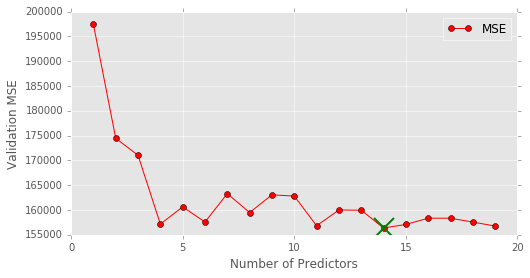

In [61]:
# set predictors for x-axis
num_predictors = np.linspace(1,len(models),len(models))

fig, ax1 = plt.subplots(figsize=(8,4));

# add the mse and mimimum mse to the plot
ax1.plot(num_predictors, mses, 'r', marker='o', label='MSE')
ax1.plot(min_index+1, min_mse, 'gx', markersize=20, markeredgewidth=2)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Validation MSE');
ax1.legend(loc='best');

Notice that after 4 variables, the validation MSE does not changes much, it would probably be best to stick with a 4-variable model.

Finally, we perform best subset selection on the full data set, and select the best 14-variable model. It is important that we make use of the full data set in order to obtain more accurate coefficient estimates. Note that we perform best subset selection on the full data set and select the best 14-variable model, rather than simply using the variables that were obtained from the training set, because the best ten-variable model on the full data set may differ from the corresponding model on the training set.

In [26]:
# Now we construct models from the FULL DATASET selecting the best models using our best_subsets function
predictors = list(df.columns)
predictors.remove('Salary')
models = best_subsets(df, predictors, ['Salary'], max_features=19)

# Print out the Coeffecients of the 14 predictor model determined as Best by Validation approach above.
print(models[13].params)

100%|██████████| 19/19 [21:49<00:00, 68.92s/it]

const         144.679318
AtBat          -2.088328
Hits            7.643645
HmRun           2.340652
Runs           -2.358048
Walks           6.179471
CAtBat         -0.148807
CRuns           1.593162
CRBI            0.717077
CWalks         -0.856584
PutOuts         0.287618
Assists         0.367731
Errors         -3.127125
League_N       44.235227
Division_W   -112.807991
dtype: float64


In fact, we see that the best 14-variable model on the full data set has a different set of variables than the best 14-variable model on the training set.

We now try to choose among the models of different sizes using cross-validation. This approach is somewhat involved, as we must perform best subset selection within each of the k training sets. We will split the data into k=10 folds. For each fold, we will compute the best models, one per model dimension where the dimension is from one feature to all features. So in total we will have the MSE for 19 models in each of the 10 folds. We will average the MSEs across folds to get the Cross-Validation Test MSE.

In [27]:
# Create the 10 folds using sklearn KFolds
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# 10Xp matrix to store MSE for each n-variable model for each fold
mses = np.zeros([10, len(predictors)])

for train_index, test_index in kf.split(df):
    # split data for this fold
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]
    
    # compute the best model subsets using our function
    models = best_subsets(df_train, predictors, ['Salary'], max_features=19)
    
    # compute the MSE of each model
    for idx, model in enumerate(models):
        # get the predictors for this model, ignore constant
        features = list(model.params.index[1:])
    
        # get the corresponding columns of df_test
        X_test = sm.add_constant(df_test[features])
    
        # make prediction for this model
        salary_pred = model.predict(X_test)
    
        # get the MSE for this model and fold
        mses[fold, idx] = np.mean((salary_pred - df_test.Salary.values)**2)
        
# now we can compute the mean MSE across folds, one per model with idx features
cvs = np.mean(mses, axis=0) 

100%|██████████| 19/19 [18:54<00:00, 59.71s/it]


And now we plot the CV errors

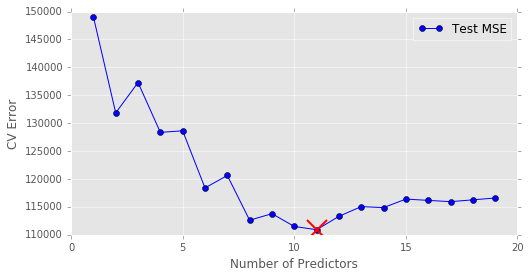

In [34]:
# We can also plot all the models CV-Errors
# set predictors for x-axis
num_predictors = np.linspace(1,len(models),len(models))

fig, ax1 = plt.subplots(figsize=(8,4));

# get the minimum in the CV
min_index, min_CV = min(enumerate(cvs), key=itemgetter(1))

# add the mse and mimimum mse to the plot
ax1.plot(num_predictors, cvs, 'b', marker='o', label='Test MSE')
ax1.plot(min_index+1, min_CV, 'rx', markersize=20, markeredgewidth=2)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('CV Error');
ax1.legend(loc='best');

So an 11 variable model yields the lowest Test MSE. The last step is to run best_subset to get the 11 variable model on the FULL dataset. 

In [31]:
# Compute the best subset models
models = best_subsets(df, predictors, ['Salary'], max_features=19)

100%|██████████| 19/19 [21:51<00:00, 69.04s/it]


In [33]:
# print the parameters of the 11th model; the model with the lowest Test MSE determined by 10-fold Cross-Validation
print(models[10].params)

const         135.751219
AtBat          -2.127748
Hits            6.923699
Walks           5.620276
CAtBat         -0.138991
CRuns           1.455331
CRBI            0.785253
CWalks         -0.822856
PutOuts         0.289409
Assists         0.268828
League_N       43.111615
Division_W   -111.146025
dtype: float64


Note: we have written several functions for doing subset selection: best_subsets, forward_step_select, and loops for doing predictions. It would be a good idea to roll all this functionality into a class called "sub_select" with methods to perform each of the operations we carried out here.